In [1]:
# Imports

import pandas as pd
import numpy as np
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

import itertools

2023-06-08 21:50:24.830612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 21:50:25.082259: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-08 21:50:26.040656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ruben/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-06-08 21:50:26.041029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'

## Fetching data
using Yahoo Finance

In [2]:
# Built in tickers that come with FinRL
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [3]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

In [4]:
df_raw = YahooDownloader(start_date=TRAIN_START_DATE,
                        end_date=TRADE_END_DATE,
                        ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.754725,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.422924,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.308592,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941086,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.408834,7117200,CAT,4


## Data Preparation
Using built-in functionality to:
 - add technical indicators
 - add a turbulence index

Technically both are optional and can be ignored, for now we add them

In [6]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [7]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature=False # Presumable this would be a way for your own features, it does not work that way though
)

df_processed = fe.preprocess_data(df_raw)
df_processed.head()

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3228, 8)
Successfully added vix
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.754725,746015200,AAPL,4,0.0,2.977271,2.648438,100.0,66.666667,100.0,2.754725,2.754725,39.189999,0.0
1,2009-01-02,58.590000,59.080002,57.750000,43.422924,6547900,AMGN,4,0.0,2.977271,2.648438,100.0,66.666667,100.0,43.422924,43.422924,39.189999,0.0
2,2009-01-02,18.570000,19.520000,18.400000,15.308592,10955700,AXP,4,0.0,2.977271,2.648438,100.0,66.666667,100.0,15.308592,15.308592,39.189999,0.0
3,2009-01-02,42.799999,45.560001,42.779999,33.941086,7010200,BA,4,0.0,2.977271,2.648438,100.0,66.666667,100.0,33.941086,33.941086,39.189999,0.0
4,2009-01-02,44.910000,46.980000,44.709999,31.408834,7117200,CAT,4,0.0,2.977271,2.648438,100.0,66.666667,100.0,31.408834,31.408834,39.189999,0.0


These next few steps are *very specific preprocessing* because of how FinRL expects the index of the dataframe to function.

Long story short, the environment iterates through each "day" using the index of the DataFrame, so it needs to fetch *all* of the day's data using that index look-up linked above. It's very annoying, but as long as you know the boilerplate, it is okay.

In [8]:
list_ticker = df_processed['tic'].unique().tolist()
list_date = list(pd.date_range(df_processed['date'].min(), df_processed['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

In [9]:
processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(df_processed, on=["date","tic"], how="left")
processed_full = processed_full[processed_full['date'].isin(df_processed['date'])]
processed_full = processed_full.sort_values(['date', 'tic'])
processed_full = processed_full.fillna(0)
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.754725,746015200.0,4.0,0.000000,2.977271,2.648438,100.000000,66.666667,100.000000,2.754725,2.754725,39.189999,0.000000
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.422924,6547900.0,4.0,0.000000,2.977271,2.648438,100.000000,66.666667,100.000000,43.422924,43.422924,39.189999,0.000000
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.308592,10955700.0,4.0,0.000000,2.977271,2.648438,100.000000,66.666667,100.000000,15.308592,15.308592,39.189999,0.000000
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941086,7010200.0,4.0,0.000000,2.977271,2.648438,100.000000,66.666667,100.000000,33.941086,33.941086,39.189999,0.000000
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.408834,7117200.0,4.0,0.000000,2.977271,2.648438,100.000000,66.666667,100.000000,31.408834,31.408834,39.189999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135773,2021-10-27,UNH,454.640015,460.440002,453.480011,444.706329,3520400.0,2.0,11.436083,455.178453,365.075615,65.085951,174.317916,51.571330,407.118555,407.405373,16.980000,145.285645
135774,2021-10-27,V,224.750000,224.750000,215.660004,212.950577,22958100.0,2.0,0.013852,233.929291,215.684808,41.737206,-153.736985,30.337021,223.913917,226.131640,16.980000,145.285645
135775,2021-10-27,VZ,53.169998,53.200001,52.470001,48.326458,15007400.0,2.0,-0.224468,50.104367,46.982813,44.604905,-50.031241,8.504850,48.783063,49.410774,16.980000,145.285645
135776,2021-10-27,WBA,48.450001,48.459999,47.090000,43.363171,5652000.0,2.0,-0.015119,46.076061,42.191733,46.167776,-62.463750,5.045608,44.342032,44.670442,16.980000,145.285645


In [10]:
df_train = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
df_test = data_split(processed_full, TRADE_START_DATE, TRADE_END_DATE)

print(len(df_train))
print(len(df_test))

83897
9715


In [11]:
# Save the data
df_train.to_csv("train_data.csv")
df_test.to_csv("test_data.csv")

In [12]:
#Just a backup incase I want to reload the data from disk
train = pd.read_csv('train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.754725,746015200.0,4.0,0.0,2.977271,2.648438,100.0,66.666667,100.0,2.754725,2.754725,39.189999,0.0
0,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.422924,6547900.0,4.0,0.0,2.977271,2.648438,100.0,66.666667,100.0,43.422924,43.422924,39.189999,0.0
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.308592,10955700.0,4.0,0.0,2.977271,2.648438,100.0,66.666667,100.0,15.308592,15.308592,39.189999,0.0
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941086,7010200.0,4.0,0.0,2.977271,2.648438,100.0,66.666667,100.0,33.941086,33.941086,39.189999,0.0
0,2009-01-02,CAT,44.910000,46.980000,44.709999,31.408834,7117200.0,4.0,0.0,2.977271,2.648438,100.0,66.666667,100.0,31.408834,31.408834,39.189999,0.0


## Define the Environment
May be worth reading into why our state requires 291 elements to describe completely. not sure why we need an extra 1, or why we need 2x our stock dimension. But let's trust it for now.

In [13]:
stock_dimension = len(df_train.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension # maybe date + open/close + indicators?
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [14]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension # The cost of purchasing
num_stock_shares = [0] * stock_dimension # Initial stock allocation (ie. we start with owning only cash)

env_kwargs = {
    'hmax': 100, # Number of shares allowed to buy or sell at any given step
    'initial_amount': 1_000_000,
    'num_stock_shares': num_stock_shares,
    'buy_cost_pct': buy_cost_list,
    'sell_cost_pct': sell_cost_list,
    'state_space': state_space,
    'stock_dim': stock_dimension,
    'tech_indicator_list': INDICATORS,
    'action_space': stock_dimension,
    'reward_scaling': 1e-4
}

e_train_gym = StockTradingEnv(df = df_train, **env_kwargs)

In [15]:
env_train, _ = e_train_gym.get_sb_env()
type(env_train) # Gets back a stable_baselines3 gym environment

stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv

## Defining & Training the agents

In [17]:
from stable_baselines3.common.logger import configure

agent = DRLAgent(env = env_train)


# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

## A2C Agent

In [18]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c", policy="MlpPolicy")

if if_using_a2c:
    # set up logger
    tmp_path = RESULTS_DIR + '/a2c'
    new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [19]:
# This step can take a while, so be patient
trained_a2c = agent.train_model(
    model=model_a2c,
    tb_log_name='a2c',
    total_timesteps=50_000
) if if_using_a2c else None

-------------------------------------
| time/                 |           |
|    fps                | 125       |
|    iterations         | 100       |
|    time_elapsed       | 3         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -139      |
|    reward             | 0.1294784 |
|    std                | 1         |
|    value_loss         | 13.1      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 120        |
|    iterations         | 200        |
|    time_elapsed       | 8          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 5.96e-08   |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 130       |
|    iterations         | 1500      |
|    time_elapsed       | 57        |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | -130      |
|    reward             | 3.8732066 |
|    std                | 1         |
|    value_loss         | 16.9      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 131       |
|    iterations         | 1600      |
|    time_elapsed       | 60        |
|    total_timesteps    | 8000      |
| train/                |           |
|    entropy_loss       | -41.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updat

-------------------------------------
| time/                 |           |
|    fps                | 136       |
|    iterations         | 2900      |
|    time_elapsed       | 106       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -69.4     |
|    reward             | 1.2325596 |
|    std                | 1.01      |
|    value_loss         | 3.32      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 136       |
|    iterations         | 3000      |
|    time_elapsed       | 109       |
|    total_timesteps    | 15000     |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updat

------------------------------------
| time/                 |          |
|    fps                | 138      |
|    iterations         | 4300     |
|    time_elapsed       | 154      |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -41.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4299     |
|    policy_loss        | -121     |
|    reward             | 3.463552 |
|    std                | 1.01     |
|    value_loss         | 10.8     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 138       |
|    iterations         | 4400      |
|    time_elapsed       | 158       |
|    total_timesteps    | 22000     |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 43

--------------------------------------
| time/                 |            |
|    fps                | 138        |
|    iterations         | 5700       |
|    time_elapsed       | 205        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -41.6      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 5699       |
|    policy_loss        | -171       |
|    reward             | -3.2516441 |
|    std                | 1.02       |
|    value_loss         | 26.6       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 138       |
|    iterations         | 5800      |
|    time_elapsed       | 209       |
|    total_timesteps    | 29000     |
| train/                |           |
|    entropy_loss       | -41.5     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

-------------------------------------
| time/                 |           |
|    fps                | 138       |
|    iterations         | 7100      |
|    time_elapsed       | 256       |
|    total_timesteps    | 35500     |
| train/                |           |
|    entropy_loss       | -41.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 7099      |
|    policy_loss        | 48.9      |
|    reward             | 1.810205  |
|    std                | 1.02      |
|    value_loss         | 2.47      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 138       |
|    iterations         | 7200      |
|    time_elapsed       | 260       |
|    total_timesteps    | 36000     |
| train/                |           |
|    entropy_loss       | -41.7     |
|    explained_variance | -0.016    |
|    learning_rate      | 0.0007    |
|    n_updat

--------------------------------------
| time/                 |            |
|    fps                | 139        |
|    iterations         | 8500       |
|    time_elapsed       | 305        |
|    total_timesteps    | 42500      |
| train/                |            |
|    entropy_loss       | -41.7      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 8499       |
|    policy_loss        | -28.7      |
|    reward             | 0.55197674 |
|    std                | 1.02       |
|    value_loss         | 1.45       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 139       |
|    iterations         | 8600      |
|    time_elapsed       | 308       |
|    total_timesteps    | 43000     |
| train/                |           |
|    entropy_loss       | -41.7     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

---------------------------------------
| time/                 |             |
|    fps                | 139         |
|    iterations         | 9900        |
|    time_elapsed       | 354         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -42         |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0007      |
|    n_updates          | 9899        |
|    policy_loss        | -5.33       |
|    reward             | -0.13498026 |
|    std                | 1.03        |
|    value_loss         | 0.297       |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 139       |
|    iterations         | 10000     |
|    time_elapsed       | 357       |
|    total_timesteps    | 50000     |
| train/                |           |
|    entropy_loss       | -42       |
|    explained_variance | 0         |
|    learning_rate

In [20]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

In [21]:
df_a2c = pd.read_csv("results/a2c/progress.csv")
df_a2c.head()

,train/std,time/total_timesteps,train/n_updates,train/policy_loss,train/entropy_loss,time/iterations,train/explained_variance,train/value_loss,time/time_elapsed,train/reward,time/fps,train/learning_rate
0,1.003940,500,99,-139.298813,-41.259136,100,0.000000e+00,13.148880,3,0.129478,125,0.0007
1,1.006239,1000,199,-119.199913,-41.315910,200,5.960464e-08,11.292726,8,-0.802021,120,0.0007
2,1.005382,1500,299,-199.520813,-41.298351,300,0.000000e+00,26.400482,11,5.414008,126,0.0007
3,1.004434,2000,399,-86.697495,-41.268509,400,-1.192093e-07,6.377907,15,2.701456,125,0.0007
4,1.004648,2500,499,324.011932,-41.282719,500,0.000000e+00,94.332352,20,-6.771104,122,0.0007


<AxesSubplot: xlabel='train/n_updates'>

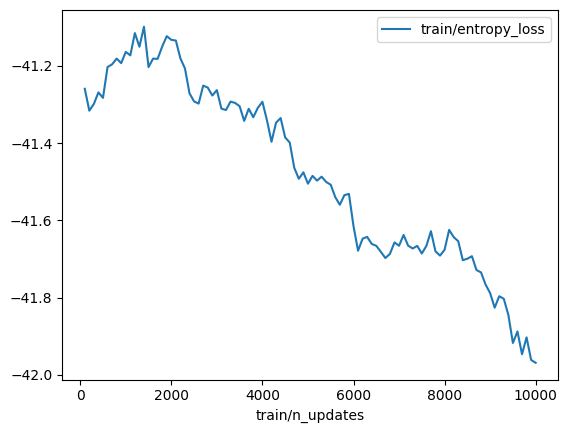

In [22]:
%matplotlib inline
df_a2c.plot(x="train/n_updates", y="train/entropy_loss")

# DDPG Agent

In [23]:
agent = DRLAgent(env=env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
    # set up logger
    tmp_path = RESULTS_DIR + '/ddpg'
    new_logger_ddpg = configure(tmp_path, ['stdout', 'csv', 'tensorboard'])
    # set new logger
    model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [24]:
trained_ddpg = agent.train_model(model=model_ddpg,
                                 tb_log_name='ddpg',
                                 total_timesteps=50_000
                                ) if if_using_ddpg else None

day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 5206418.29
total_reward: 4206418.29
total_cost: 5131.96
total_trades: 49022
Sharpe: 0.926
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 66        |
|    time_elapsed    | 173       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 23.9      |
|    critic_loss     | 3.07e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 8679      |
|    reward          | 6.8471007 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 59        |
|    time_elapsed    | 387       |
|    total_timesteps | 23144     |
| train/             |           |
|    actor_loss      | -35.3     |
|    critic_loss     | 40.7      |
|    learning_rate   | 0.001     |
|    n_updates       | 20251     |


In [25]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

In [26]:
df_ddpg = pd.read_csv("results/ddpg/progress.csv")
df_ddpg.head()

,time/total_timesteps,train/n_updates,time/episodes,train/actor_loss,time/time_elapsed,train/reward,train/critic_loss,time/fps,train/learning_rate
0,11572,8679,4,23.875779,173,6.847101,3073.164375,66,0.001
1,23144,20251,8,-35.344579,387,6.847101,40.703364,59,0.001
2,34716,31823,12,-29.103751,593,6.847101,9.400782,58,0.001
3,46288,43395,16,-22.846522,800,6.847101,5.568804,57,0.001


<AxesSubplot: xlabel='train/n_updates'>

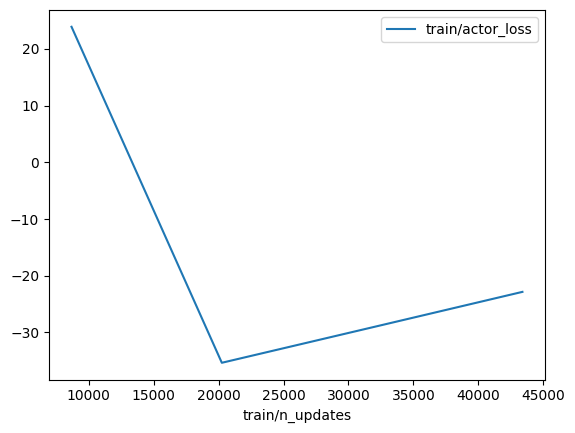

In [28]:
df_ddpg.plot(x="train/n_updates", y="train/actor_loss")

## PPO Agent

In [29]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128
}
model_ppo = agent.get_model("ppo", model_kwargs = PPO_PARAMS)

if if_using_ppo:
    # set up logger
    tmp_path = RESULTS_DIR + '/ppo'
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [30]:
trained_ppo = agent.train_model(model=model_ppo,
                                tb_log_name='ppo',
                                total_timesteps=50_000
                               ) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 149       |
|    iterations      | 1         |
|    time_elapsed    | 13        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.1520569 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 150         |
|    iterations           | 2           |
|    time_elapsed         | 27          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016970556 |
|    clip_fraction        | 0.23        |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00132     |
|    learning_rate        | 0.00025     |
|    loss                 | 6.88        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0256     |
|    reward  

-----------------------------------------
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 12          |
|    time_elapsed         | 161         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.023811925 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.5       |
|    explained_variance   | -0.00579    |
|    learning_rate        | 0.00025     |
|    loss                 | 16.4        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0172     |
|    reward               | 0.5997187   |
|    std                  | 1.01        |
|    value_loss           | 20.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 13    

-----------------------------------------
| time/                   |             |
|    fps                  | 151         |
|    iterations           | 22          |
|    time_elapsed         | 296         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.030490551 |
|    clip_fraction        | 0.246       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.9       |
|    explained_variance   | 0.012       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.1        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0111     |
|    reward               | 2.665697    |
|    std                  | 1.03        |
|    value_loss           | 32.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 23    

In [31]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

In [32]:
df_ppo = pd.read_csv("results/ppo/progress.csv")
df_ppo.head()

,time/time_elapsed,train/reward,time/total_timesteps,time/fps,time/iterations,train/clip_fraction,train/std,train/n_updates,train/entropy_loss,train/approx_kl,train/clip_range,train/loss,train/explained_variance,train/value_loss,train/policy_gradient_loss,train/learning_rate
0,13,0.152057,2048,149,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27,0.834323,4096,150,2,0.229980,1.002055,10.0,-41.176287,0.016971,0.2,6.878367,0.001316,13.371425,-0.025602,0.00025
2,40,-1.295663,6144,152,3,0.174707,1.003433,20.0,-41.225238,0.016776,0.2,36.355598,-0.002024,52.635003,-0.020346,0.00025
3,53,2.638396,8192,152,4,0.204785,1.004743,30.0,-41.264761,0.016156,0.2,11.016659,-0.008430,49.946877,-0.020431,0.00025
4,67,2.232315,10240,152,5,0.170557,1.004520,40.0,-41.279849,0.015049,0.2,5.918926,-0.008051,14.521743,-0.017605,0.00025


<AxesSubplot: xlabel='train/n_updates'>

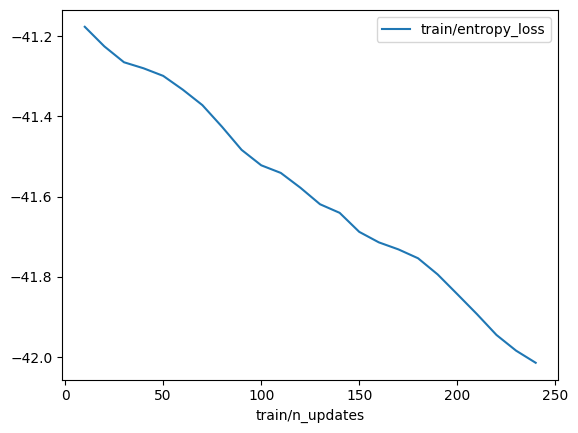

In [33]:
df_ppo.plot(x="train/n_updates", y="train/entropy_loss")

## TD3 Agent

In [34]:
agent = DRLAgent(env=env_train)
TD3_PARAMS = {'batch_size': 100, 
              'buffer_size': 1_000_000,
              'learning_rate': 0.001
             }

model_td3 = agent.get_model("td3", model_kwargs = TD3_PARAMS)

if if_using_td3:
    # set up a logger
    tmp_path = RESULTS_DIR + '/td3'
    new_logger_td3 = configure(tmp_path, ['stdout', 'csv', 'tensorboard'])
    # set new logger
    model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [35]:
trained_td3 = agent.train_model(model=model_td3,
                                tb_log_name='td3',
                                total_timesteps=50_000
                               ) if if_using_td3 else None

day: 2892, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 5029463.91
total_reward: 4029463.91
total_cost: 999.00
total_trades: 37596
Sharpe: 0.870
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 69       |
|    time_elapsed    | 167      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | 107      |
|    critic_loss     | 5.89e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 8679     |
|    reward          | 5.680432 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 62       |
|    time_elapsed    | 368      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | 44.8     |
|    critic_loss     | 2.7e+03  |
|    learning_rate   | 0.001    |
|    n_updates       | 20251    |
|    reward          | 5.

In [36]:
trained_td3.save(TRAINED_MODEL_DIR + '/agent_td3') if if_using_td3 else None

## Calculate Out-of-sample performance

In [40]:
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

# Load our saved models
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c")
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg")
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo")
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3")

In [41]:
# Let's set-up our testing environment now
e_test_gym = StockTradingEnv(
    df = df_test,
    turbulence_threshold=70,
    risk_indicator_col='vix',
    **env_kwargs
)

## Make predictions using trained agents

In [45]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment=e_test_gym
)

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment=e_test_gym
)

df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment=e_test_gym
)

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment=e_test_gym
)

hit end!
hit end!
day: 334, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1289960.61
total_reward: 289960.61
total_cost: 2289.18
total_trades: 5194
Sharpe: 1.514
hit end!
hit end!


In [46]:
df_account_value_a2c = df_account_value_a2c.set_index('date')
df_account_value_a2c.columns=['A2C']

df_account_value_ddpg = df_account_value_ddpg.set_index('date')
df_account_value_ddpg.columns=['DDPG']

df_account_value_ppo = df_account_value_ppo.set_index('date')
df_account_value_ppo.columns=['PPO']

df_account_value_td3 = df_account_value_td3.set_index('date')
df_account_value_td3.columns=['TD3']

In [47]:
df_agent_results = pd.concat([df_account_value_a2c, df_account_value_ddpg, df_account_value_ppo, df_account_value_td3], axis=1)
df_agent_results.index = pd.to_datetime(df_agent_results.index)
df_agent_results

,A2C,DDPG,PPO,TD3
date,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2020-07-02,1.000410e+06,1.000940e+06,1.000032e+06,1.000055e+06
2020-07-06,1.004669e+06,1.003435e+06,1.001296e+06,1.004573e+06
2020-07-07,9.973401e+05,9.994076e+05,1.000064e+06,1.000592e+06
2020-07-08,1.000733e+06,1.002122e+06,1.001127e+06,1.004419e+06
...,...,...,...,...
2021-10-21,1.438240e+06,1.308891e+06,1.290953e+06,1.448593e+06
2021-10-22,1.450003e+06,1.313428e+06,1.296140e+06,1.453793e+06
2021-10-25,1.445409e+06,1.319058e+06,1.295395e+06,1.455698e+06


In [50]:
!pip install plotnine

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 62.2 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 33.8 MB/s eta 0:00:00
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflowjs 3.20.0 requires packaging~=20.9, but you have packaging 23.1 which is incompatible.


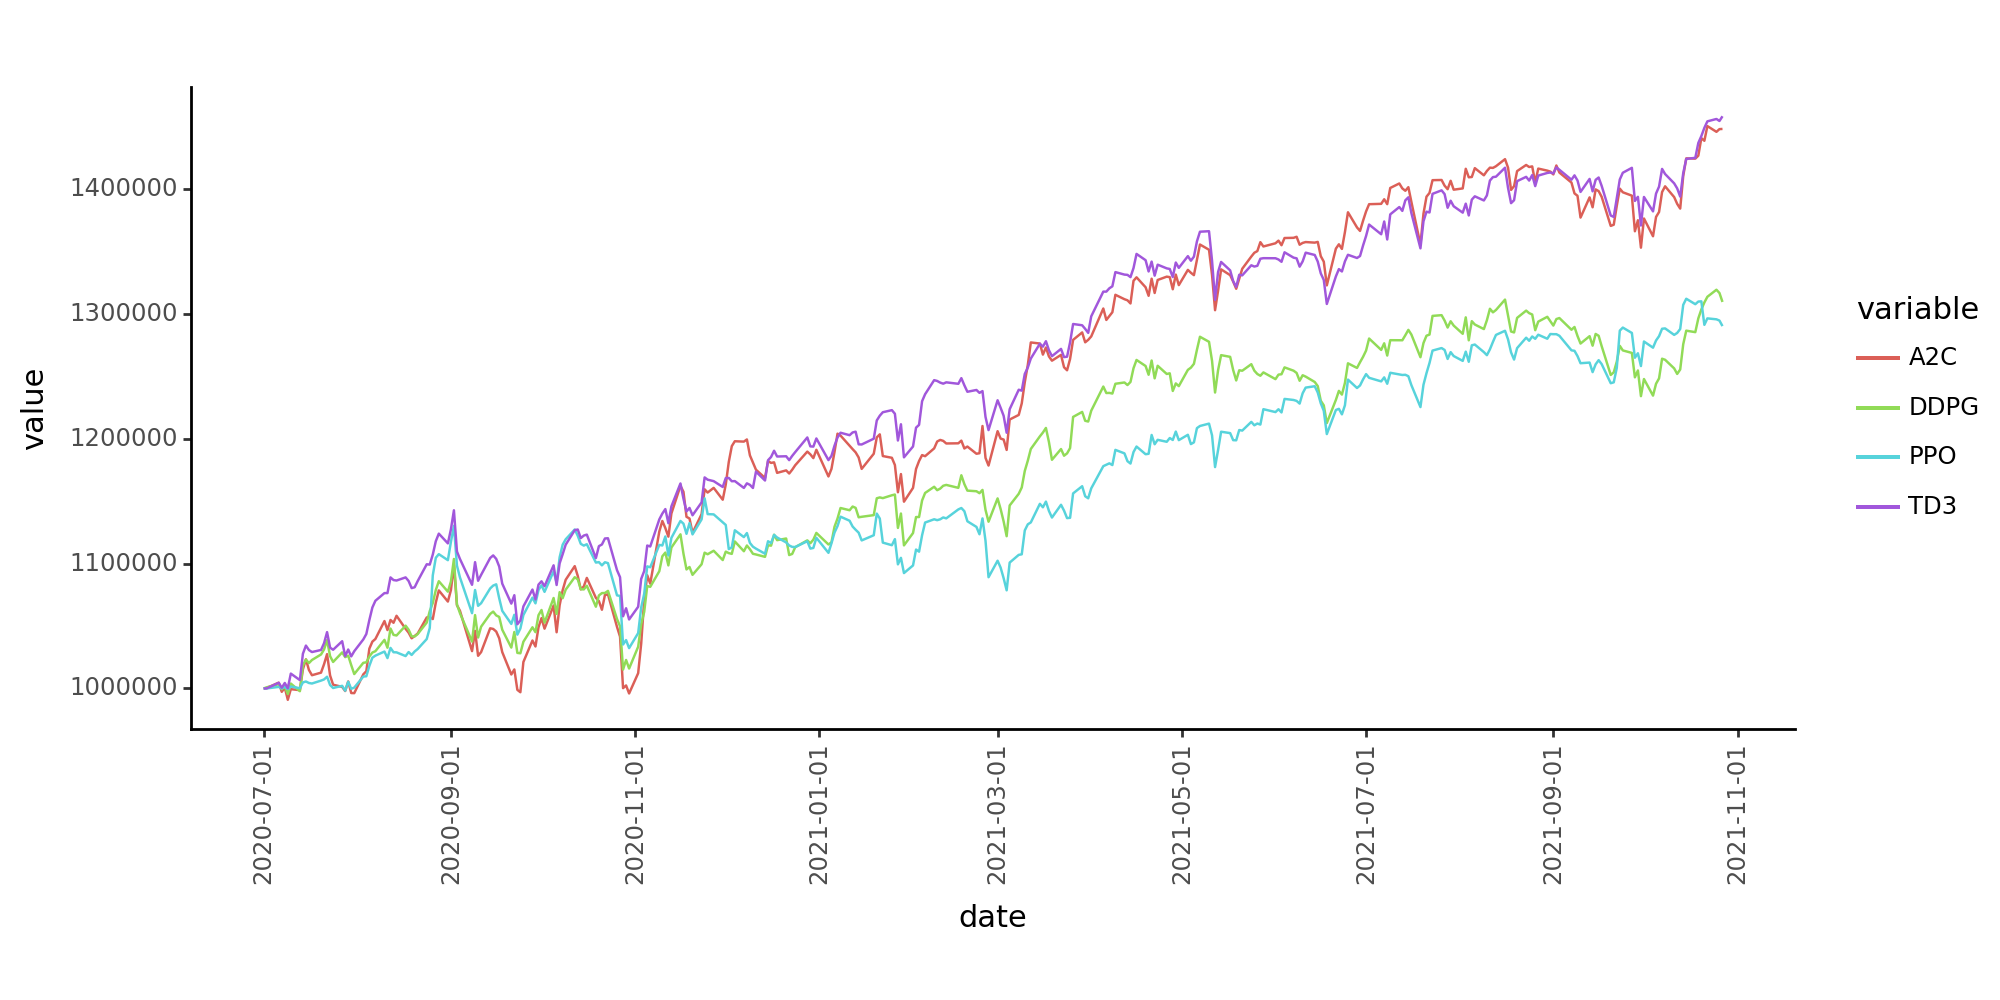

<Figure Size: (1000 x 500)>

In [51]:
from plotnine import * 

# Same massaging to make the data 'tidy'
df_agent_results_plot = df_agent_results.reset_index().melt(id_vars='date')

# Let's draw the plot
p = ggplot(df_agent_results_plot, aes(x='date', y='value', color='variable'))
p + geom_line() + theme_classic() + theme(axis_text_x=element_text(rotation=90), aspect_ratio=0.4, figure_size=(10, 5))

In [58]:
df_actions_td3

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,100,0,100,0,0,0,100,0,100,0,...,100,100,0,0,100,0,0,100,0,100
2020-07-02,100,0,100,0,0,0,100,0,100,0,...,100,100,0,0,100,0,0,100,0,100
2020-07-06,100,0,100,0,0,0,100,0,100,0,...,100,100,0,0,100,0,0,100,0,100
2020-07-07,100,0,100,0,0,0,100,0,100,0,...,100,100,0,0,100,0,0,100,0,100
2020-07-08,100,0,100,0,0,0,100,0,100,0,...,100,100,0,0,100,0,0,100,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-10-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-10-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
df_actions_a2c.iloc[0]

AAPL     46
AMGN     15
AXP     100
BA      100
CAT       0
CRM       0
CSCO      0
CVX       0
DIS       0
GS        0
HD        0
HON       5
IBM     100
INTC     11
JNJ       0
JPM      33
KO      100
MCD       0
MMM      11
MRK       0
MSFT    100
NKE      66
PG        0
TRV       0
UNH     100
V         0
VZ      100
WBA      16
WMT      39
Name: 2020-07-01, dtype: int64